In [1]:
from pycalphad import Database, calculate, equilibrium, variables as v
import matplotlib.pyplot as plt
from pycalphad import Database, binplot
import pycalphad.variables as v

In [7]:
dbf = Database('../tdbs/ssubhydrides.TDB')
comps = ['LI', 'H', 'VA']
phases = ['H1LI1_L', 'H1LI1_S', 'LI_L', 'LI_S']
eq_result = equilibrium(dbf, comps , phases, {v.N:1, v.X('LI'):0.5, v.T: (300, 1300, 25), v.P:101325}, output='HM')
print(eq_result)

<xarray.Dataset> Size: 9kB
Dimensions:    (N: 1, P: 1, T: 40, X_LI: 1, vertex: 3, component: 2,
                internal_dof: 1)
Coordinates:
  * N          (N) float64 8B 1.0
  * P          (P) float64 8B 1.013e+05
  * T          (T) float64 320B 300.0 325.0 350.0 ... 1.25e+03 1.275e+03
  * X_LI       (X_LI) float64 8B 0.5
  * vertex     (vertex) int64 24B 0 1 2
  * component  (component) <U2 16B 'H' 'LI'
Dimensions without coordinates: internal_dof
Data variables:
    NP         (N, P, T, X_LI, vertex) float64 960B 1.0 nan nan ... 1.0 nan nan
    GM         (N, P, T, X_LI) float64 320B -4.842e+04 -4.869e+04 ... -8.036e+04
    MU         (N, P, T, X_LI, component) float64 640B -4.842e+04 ... -8.036e+04
    X          (N, P, T, X_LI, vertex, component) float64 2kB 0.5 0.5 ... nan
    Y          (N, P, T, X_LI, vertex, internal_dof) float64 960B 1.0 ... nan
    Phase      (N, P, T, X_LI, vertex) <U7 3kB 'H1LI1_S' '' '' ... '' ''
    HM         (N, P, T, X_LI) float64 320B -4.53e+04 -4.4

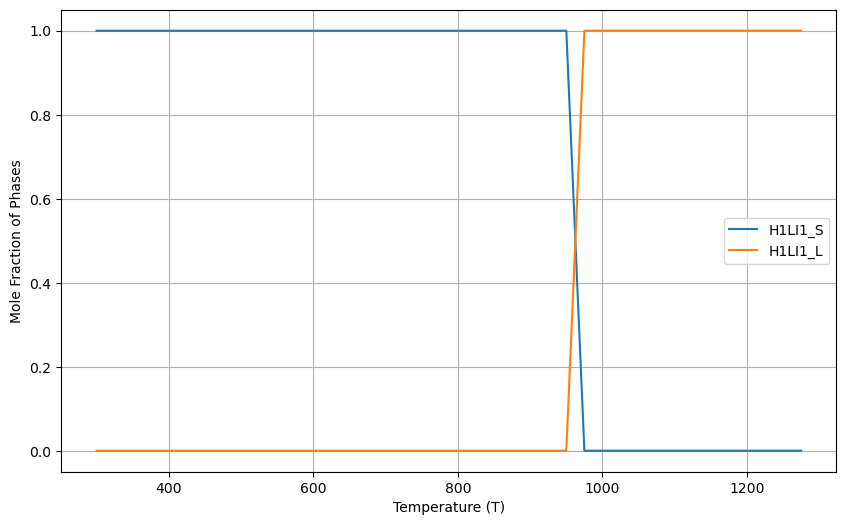

In [8]:
# Assuming `data1` and `data2` are your xarray DataArrays
data1 = eq_result.NP.where(eq_result.Phase=='H1LI1_S').sel(P=101325).sel(vertex=0).fillna(0)
data2 = eq_result.NP.where(eq_result.Phase=='H1LI1_L').sel(P=101325).sel(vertex=0).fillna(0)

# Create the plot
plt.figure(figsize=(10, 6))
data1.plot(label='H1LI1_S')
data2.plot(label='H1LI1_L')
plt.title('')
plt.xlabel('Temperature (T)')
plt.ylabel('Mole Fraction of Phases')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
dbf = Database('../tdbs/ssubhydrides.TDB')
comps = ['NA', 'H', 'VA']
phases = ['H1NA1_S', 'NA_S', 'NA_L', 'GAS']
eq_result = equilibrium(dbf, comps , phases, {v.N:1, v.X('NA'):0.5, v.T: (300, 1300, 25), v.P:101325}, output='HM')
print(eq_result.NP.where(eq_result.Phase=='NA_L').sel(P=101325).sel(vertex=0).fillna(0))

<xarray.DataArray 'NP' (N: 1, T: 40, X_NA: 1)> Size: 320B
array([[[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]]])
Coordinates:
  * N        (N) float64 8B 1.0
    P        float64 8B 1.013e+05
  * T        (T) float64 320B 300.0 325.0 350.0 ... 1.225e+03 1.25e+03 1.275e+03
  * X_NA     (X_NA) float64 8B 0.5
    vertex   int64 8B 0


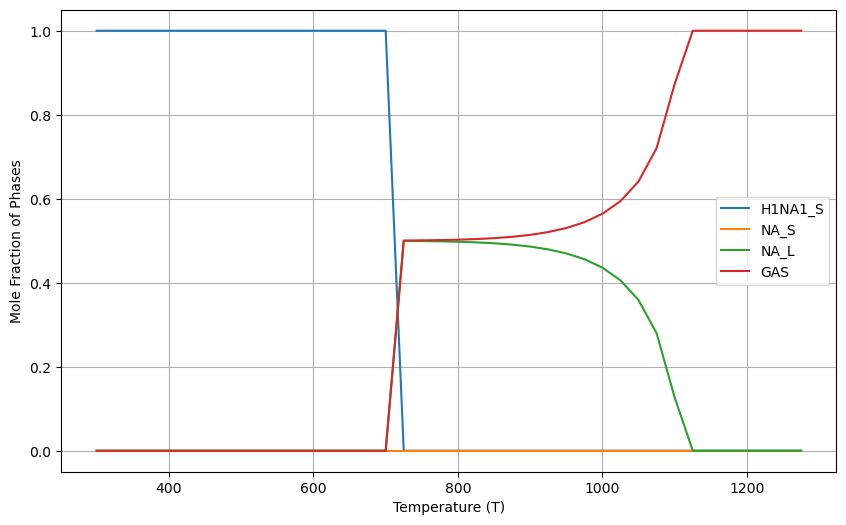

In [11]:
# Assuming `data1` and `data2` are your xarray DataArrays
data1 = eq_result.NP.where(eq_result.Phase=='H1NA1_S').sel(P=101325).sel(vertex=0).fillna(0)
data2 = eq_result.NP.where(eq_result.Phase=='NA_S').sel(P=101325).sel(vertex=0).fillna(0)
data3 = eq_result.NP.where(eq_result.Phase=='NA_L').sel(P=101325).sel(vertex=1).fillna(0)
data4 = eq_result.NP.where(eq_result.Phase=='GAS').sel(P=101325).sel(vertex=0).fillna(0)

# Create the plot
plt.figure(figsize=(10, 6))
data1.plot(label='H1NA1_S')
data2.plot(label='NA_S')
data3.plot(label='NA_L')
data4.plot(label='GAS')
plt.title('')
plt.xlabel('Temperature (T)')
plt.ylabel('Mole Fraction of Phases')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
dbf = Database('../tdbs/ssubhydrides.TDB')
comps = ['LI', 'B', 'H', 'VA']
phases = ['B1H4LI1_S', 'H1LI1_S', 'B_S', 'GAS']
eq_result = equilibrium(dbf, comps , phases, {v.N:1, v.X('LI'):0.1667, v.X('B'):0.1667, v.T: (300, 825, 25), v.P:101325}, output='HM')
print(eq_result)

<xarray.Dataset> Size: 16kB
Dimensions:    (N: 1, P: 1, T: 21, X_B: 1, X_LI: 1, vertex: 4, component: 3,
                internal_dof: 13)
Coordinates:
  * N          (N) float64 8B 1.0
  * P          (P) float64 8B 1.013e+05
  * T          (T) float64 168B 300.0 325.0 350.0 375.0 ... 750.0 775.0 800.0
  * X_B        (X_B) float64 8B 0.1667
  * X_LI       (X_LI) float64 8B 0.1667
  * vertex     (vertex) int64 32B 0 1 2 3
  * component  (component) <U2 24B 'B' 'H' 'LI'
Dimensions without coordinates: internal_dof
Data variables:
    NP         (N, P, T, X_B, X_LI, vertex) float64 672B 6.667e-05 ... nan
    GM         (N, P, T, X_B, X_LI) float64 168B -3.553e+04 ... -4.943e+04
    MU         (N, P, T, X_B, X_LI, component) float64 504B -1.77e+03 ... -6....
    X          (N, P, T, X_B, X_LI, vertex, component) float64 2kB 1.0 ... nan
    Y          (N, P, T, X_B, X_LI, vertex, internal_dof) float64 9kB 1.0 ......
    Phase      (N, P, T, X_B, X_LI, vertex) <U9 3kB 'B_S' 'B1H4LI1_S' ... '

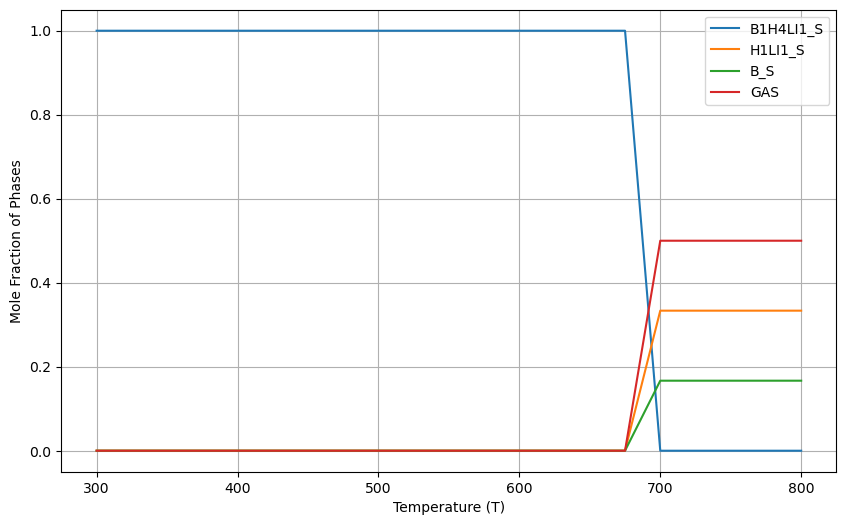

In [13]:
# Assuming `data1` and `data2` are your xarray DataArrays
data1 = eq_result.NP.where(eq_result.Phase=='B1H4LI1_S').sel(vertex=1).fillna(0)
data2 = eq_result.NP.where(eq_result.Phase=='H1LI1_S').sel(vertex=2).fillna(0)
data3 = eq_result.NP.where(eq_result.Phase=='B_S').sel(vertex=0).fillna(0)
data4 = eq_result.NP.where(eq_result.Phase=='GAS').sel(vertex=1).fillna(0)

# Create the plot
plt.figure(figsize=(10, 6))
data1.plot(label='B1H4LI1_S')
data2.plot(label='H1LI1_S')
data3.plot(label='B_S')
data4.plot(label='GAS')
plt.title('')
plt.xlabel('Temperature (T)')
plt.ylabel('Mole Fraction of Phases')
plt.legend()
plt.grid(True)
plt.show()

ValueError: Binary map requires exactly one composition and one potential coordinate

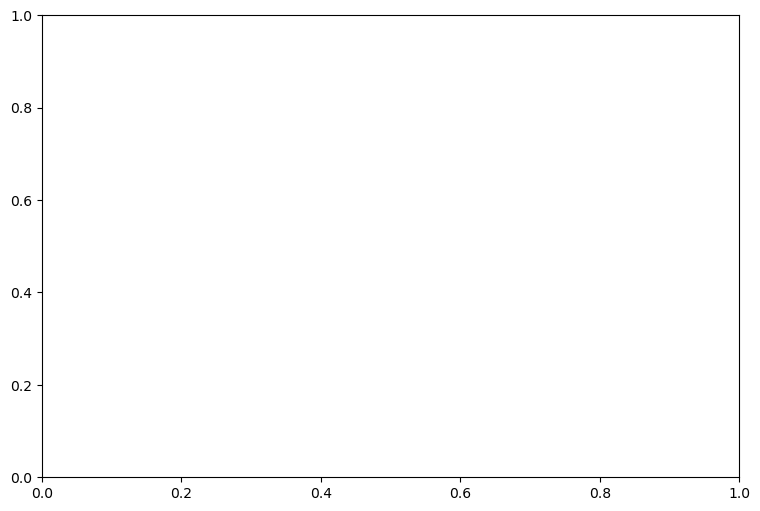

In [14]:
dbf = Database('../tdbs/ssubhydrides.TDB')
comps = ['LI', 'H', 'VA']
phases = ['H1LI1_S', 'H1LI1_L', 'LI_S', 'LI_L', 'GAS']

fig = plt.figure(figsize=(9,6))
axes = fig.gca()
binplot(dbf, comps , phases, {v.N:1, v.X('LI'):0.5, v.T:(300, 1225, 25), v.P:(1, 10^8, 1000)}, plot_kwargs={'ax': axes})
plt.show()